In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
%matplotlib inline

In [2]:
file_path = './全部数据/附件2-行业日负荷数据.csv'
data = pd.read_csv(file_path, parse_dates=['数据时间'], index_col=[1])
data

,行业类型,有功功率最大值（kw）,有功功率最小值（kw）
数据时间,,,
2019-01-01,大工业用电,117888.3300,51526.5690
2019-01-02,大工业用电,126843.7914,63638.4294
2019-01-03,大工业用电,130286.1294,102048.2754
2019-01-04,大工业用电,133018.6344,104466.0762
2019-01-05,大工业用电,133504.4784,99507.3528
...,...,...,...
2021-08-27,商业,104728.8762,19815.7638
2021-08-28,商业,93855.1368,20820.2490
2021-08-29,商业,84127.1658,21679.5828


In [3]:
data1 = data[data['行业类型'] == '大工业用电']
data2 = data[data['行业类型'] == '非普工业']
data3 = data[data['行业类型'] == '普通工业']
data4 = data[data['行业类型'] == '商业']

In [4]:
# 用原数据减去滑动平均数据的方法，求出波动图，再通过箱型图的方法将异常数据赋值为np.NaN
# prophet会根据插值的方法自动填充np.NaN值
def drop_outlier(data1, column, window=15):
    data_smooth = data1.iloc[:,column].rolling(window, center=True).mean()
    
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[j,column]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[len(data_smooth) - j - 1, column]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)
    
    data_sub = data1.iloc[:,column] - data_smooth
    
    q1 = data_sub.quantile(0.25)
    q3 = data_sub.quantile(0.75)
    
    # 分别为箱线图的上界和下界
    upper_whisker = q3 + 1.5*(q3-q1)
    lower_whisker = q1 - 1.5*(q3-q1)

    rule = (lower_whisker > data_sub) | (upper_whisker < data_sub)
    
    data_drop_outlier = data1.copy()
    data_drop_outlier.loc[rule, data_drop_outlier.columns[column]] = np.NaN
    
    return data_drop_outlier

In [55]:
def FB(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=91)
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    # fig1 = m.plot(forecast)
    # fig2 = m.plot_components(forecast)
    
    dic = {data1.columns[column]:forecast.yhat.values[-91-92:-91]}
    y_test = pd.DataFrame(dic, index=pd.date_range('2021-06', periods=92))
    y_test.index.name = '数据时间'
    return y_test

In [56]:
def predict_analysis(data1, column):
    data1_copy = drop_outlier(data1, column)
    data11_y = FB(data1_copy, column)
    
    plt.figure(figsize=(20,4))
    plt.plot(data1.iloc[-92:,column])
    plt.plot(data11_y)
    
    print('MAE:',abs(data1.iloc[-92:,column].values-data11_y.values[:,0]).sum()/92)
    print('MAPE:',abs(data1.iloc[-92:,column].values-data11_y.values[:,0]).sum()/data11_y.values[:,0].sum())
    # print('MSE:',((data1.iloc[-92:,column].values-data11_y.values[:,0])**2).sum()/92)
    # print('r2_score:',1-(((data1.iloc[-92:,column].values-data11_y.values[:,0])**2).sum())/(((data1.iloc[-92:,column].values-data1.iloc[-92:,column].values.mean())**2).sum()))

MAE: 5227.790720996292
MAPE: 0.04632425107667116


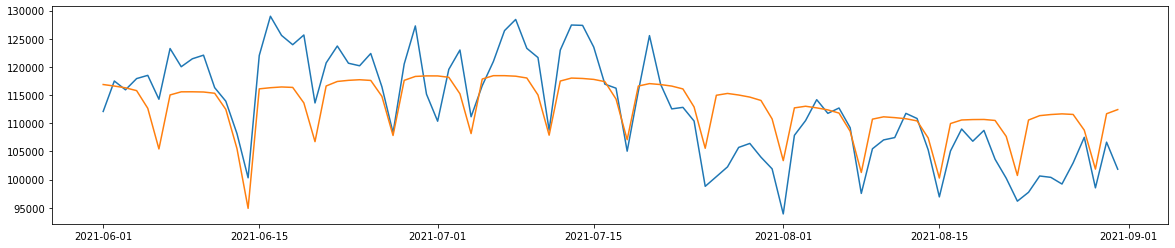

In [59]:
# 大工业最大值
predict_analysis(data1, 1)

MAE: 6778.811243492405
MAPE: 0.08010398801640266


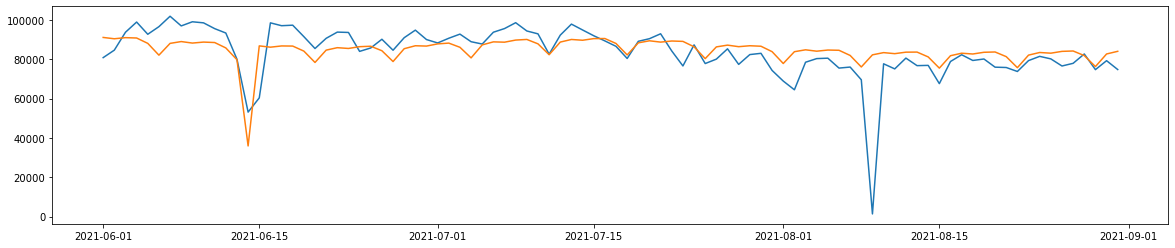

In [60]:
# 大工业最小值
predict_analysis(data1, 2)

MAE: 173.5173227625078
MAPE: 0.05676270434184371


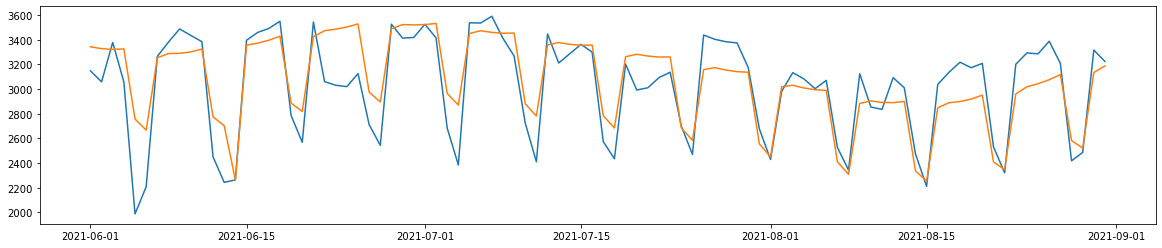

In [61]:
# 非普工业最大值
predict_analysis(data2, 1)

MAE: 139.00640150551172
MAPE: 0.09926832718575418


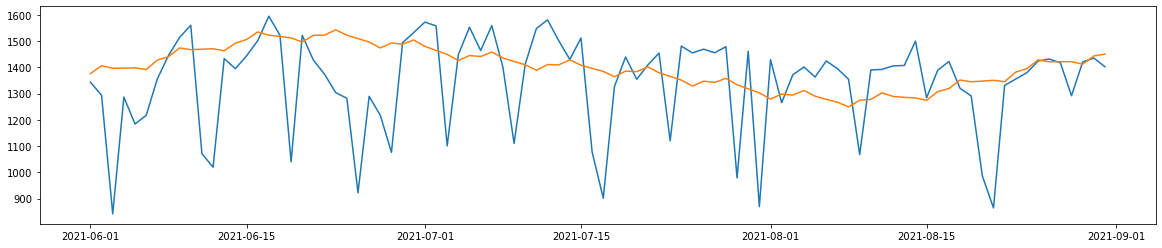

In [62]:
# 非普工业最小值
predict_analysis(data2, 2)

MAE: 700.5855835351085
MAPE: 0.07755664332835041


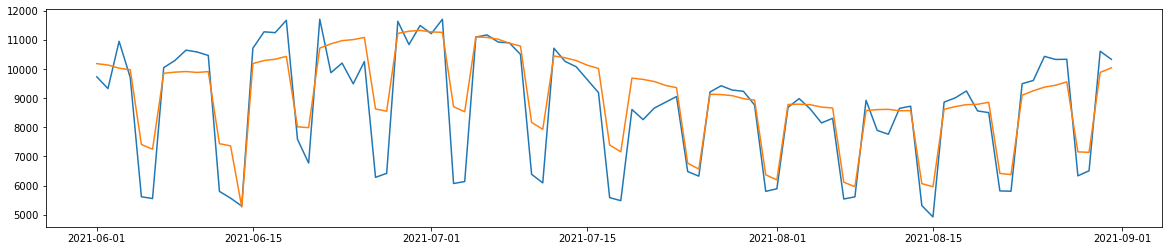

In [63]:
# 普通工业最大值
predict_analysis(data3, 1)

MAE: 405.7133404785048
MAPE: 0.1182638195563414


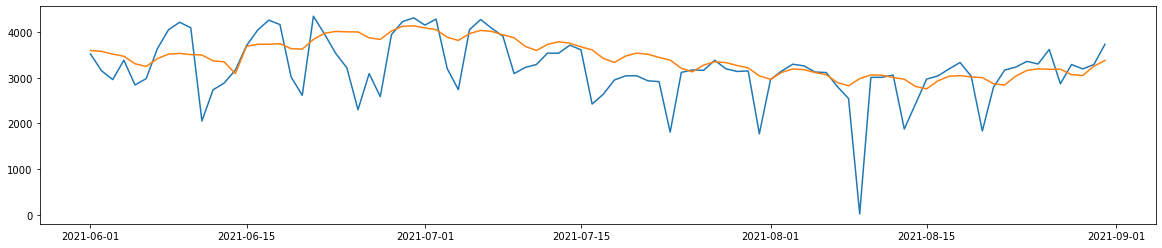

In [64]:
# 普通工业最小值
predict_analysis(data3, 2)

MAE: 6174.399264384195
MAPE: 0.06445079915082046


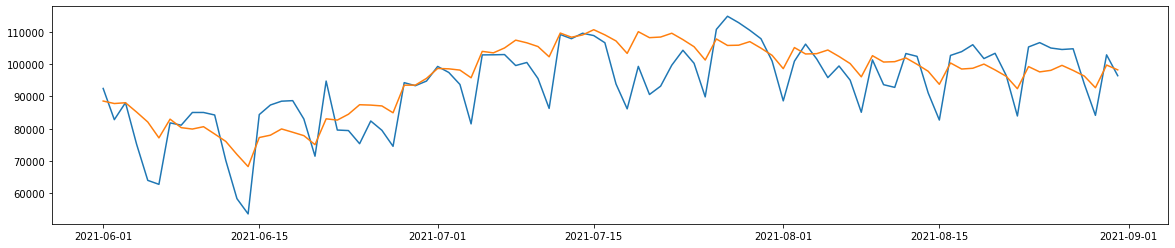

In [68]:
# 商业最大值，预测值出现负值，可见预测效果出现异常，说明数据有问题，需要手动筛选
predict_analysis(data4, 1)

MAE: 6910.792076193198
MAPE: 0.07179847256195551


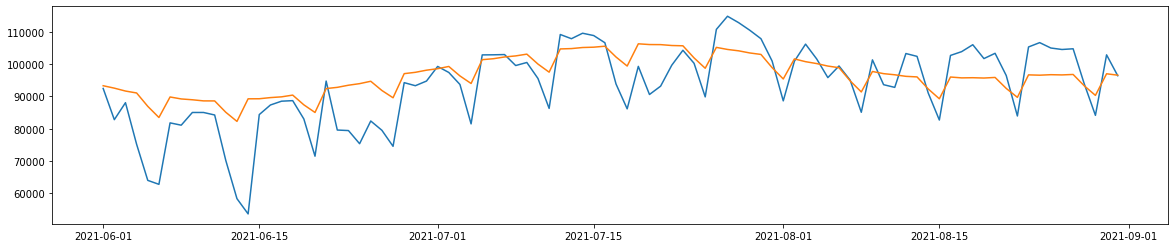

In [67]:
# 商业最大值，将2019年12月以前的数据剔除出去，预测结果正常
predict_analysis(data4['2019-12':], 1)

MAE: 1707.1542590315917
MAPE: 0.08408757335788818


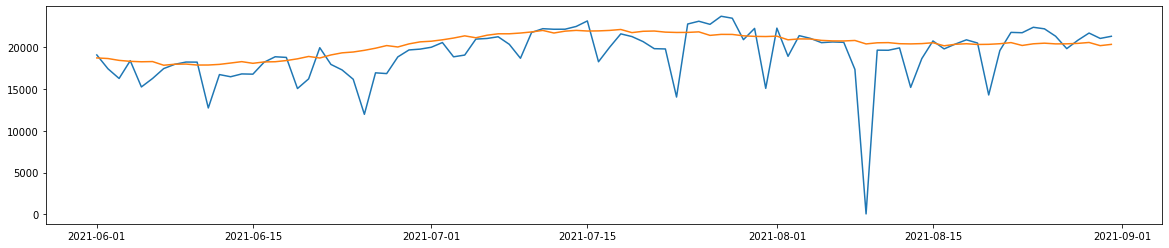

In [69]:
# 商业最小值
predict_analysis(data4, 2)